In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from sklearn import linear_model
import statsmodels.api as sm
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
# Any results you write to the current directory are saved as output.

['store.csv', 'train.csv', 'test.csv', 'sample_submission.csv']


In [28]:
givenTrain = pd.read_csv("../input/train.csv",parse_dates = ['Date'])
givenTest = pd.read_csv("../input/test.csv",parse_dates = ['Date'])
givenStore = pd.read_csv("../input/store.csv")

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [29]:
givenTrain[givenTrain.StateHoliday=="0"] = 0  #To maintain consistency in data type in this column

In [31]:
#Considering only open stores and stores with continous promotions
openStores = givenTrain[givenTrain['Open'] == 1]
givenStore = givenStore[givenStore['Promo2'] == 1]

In [32]:
combinedData = pd.merge(openStores,givenStore,how="inner")

**Feature Selection: **

    Information about competitiors are not considered for this analysis. Only information about promotions are analysed.

In [33]:
interimData = combinedData.drop(combinedData[['CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear']],axis= 1)

In [34]:
print("Ensuring if any anomalies present with Promo2 and Promo2SinceWeek :",((interimData['Promo2'] == 0) & (pd.notnull(interimData['Promo2SinceWeek']))).sum())
print("Ensuring if any anomalies present with Promo2 and Promo2SinceYear :",((interimData['Promo2'] == 0) & (pd.notnull(interimData['Promo2SinceYear']))).sum())
print("Ensuring if any anomalies present with Promo2 and PromoInterval :",((interimData['Promo2'] == 0) & (pd.notnull(interimData['PromoInterval']))).sum())

Ensuring if any anomalies present with Promo2 and Promo2SinceWeek : 0
Ensuring if any anomalies present with Promo2 and Promo2SinceYear : 0
Ensuring if any anomalies present with Promo2 and PromoInterval : 0


In [36]:
interimData['Month'] = interimData['Date'].dt.month

Since Month information is extracted from Date and Day of Week information is already available in the given dataset, 'Date' is dropped

Promo2SinceWeek and Promo2SinceYear and PromoInterval are also dropped for simplicity .

Open and Promo2 variables got same value throughtout since we filtered records with 1 on those columns above. Hence dropping them from dataset

In [37]:
dataAfterDropping = interimData.drop(interimData[['Date','Promo2SinceWeek','Promo2SinceYear','PromoInterval']],axis =1)

#To process discrete values to dummies it is converted to string
dataAfterDropping['Month'] = dataAfterDropping['Month'].astype(str)
dataAfterDropping['DayOfWeek'] = dataAfterDropping['DayOfWeek'].astype(str)

cleanDataSet = pd.get_dummies(dataAfterDropping)
cleanDataSet.drop(cleanDataSet[['Open','Promo2']],axis=1,inplace=True) #it has same value for all observations.

In [38]:
cleanDataSet.head(5)

,Store,Sales,Customers,Promo,SchoolHoliday,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,...,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9
0,96,6573,640,1,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,96,3996,505,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,96,4406,555,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,96,4287,523,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,96,1643,210,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Ordinary Least Squares to check for variables explanatory power.

X1 represents all features i.e., excluding target variable 'Sales'

y represents target variable

In [39]:
X1 = cleanDataSet.drop(cleanDataSet[['Sales','Store']],axis =1)
y = cleanDataSet['Sales']

In [40]:
X2 = sm.add_constant(X1)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     7549.
Date:                Thu, 03 May 2018   Prob (F-statistic):               0.00
Time:                        03:57:46   Log-Likelihood:            -4.5621e+05
No. Observations:               53773   AIC:                         9.125e+05
Df Residuals:                   53745   BIC:                         9.127e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -70.1875     60.707     -1.

**Intrepretation**:
    
    1)Month_11 and Month_4 are having pvalues greater than 0.05 suggesting the absence of explanatory power.
    
    Month_11 has positive co-efficient meaning that sales would be increasing irrespective of Promo2 being present during month-11.
    Month_4 has negative co-efficient meaning that sales would be decreasing irrespective of Promo2 being present during month-4.
    
    2) StateHoliday_a and StateHoliday_b are having unacceptable p-values suggesting the absence of explanatory power.

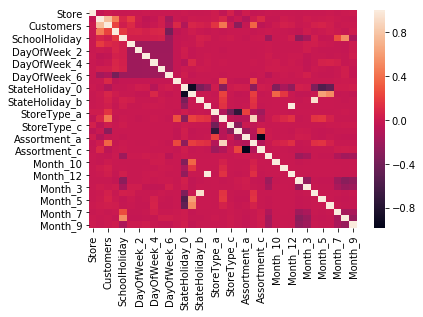

In [41]:
corr = cleanDataSet.corr()
sns.heatmap(corr)

Examining the above plot, Strong correlation is seen among variables such as 'Month_3  and StateHoliday_b'  , 'Month_5 and StateHoliday_b' .,etc


Decided to retain only one of those highly correlated variables.

In [42]:
newX = cleanDataSet.drop(cleanDataSet[['Sales','StateHoliday_b','StateHoliday_a','Assortment_a','Month_3','StoreType_a','Month_11','Month_4']],axis =1)
y1 = cleanDataSet['Sales']

In [43]:
lr = linear_model.Lasso(alpha=0.2)
lr.fit(newX,y)
print("Lasso Regression Co-efficients are:","\n")
[print(a, b) for a,b in zip(newX.columns,lr.coef_)][0]

print("\n")

rf = linear_model.Ridge()
rf.fit(newX,y)
print("Ridge Regression Co-oefficients are:","\n")
[print(a, b) for a,b in zip(newX.columns,rf.coef_)][0]


Lasso Regression Co-efficients are: 

Store -0.24331096872316638
Customers 7.0283832711638015
Promo 1388.178732979916
SchoolHoliday 135.41621406788494
DayOfWeek_1 510.16287230783325
DayOfWeek_2 -0.0
DayOfWeek_3 -123.73642816607202
DayOfWeek_4 -167.4416259511712
DayOfWeek_5 -26.818197122176958
DayOfWeek_6 352.3585427744016
DayOfWeek_7 752.037513873026
StateHoliday_0 -557.0989893360132
StateHoliday_c 87.79333072963462
StoreType_b -4482.324516988981
StoreType_c -220.22619910779602
StoreType_d 1091.3487522250052
Assortment_b -2359.0959326800557
Assortment_c 337.4601946383369
Month_1 54.77530243260837
Month_10 -1131.1219951524179
Month_12 1698.606680903592
Month_2 9.488642198472936
Month_5 -21.958566973937177
Month_6 -176.2061610678167
Month_7 21.06412962458877
Month_8 -102.17857968392974
Month_9 -169.64525662577063


Ridge Regression Co-oefficients are: 

Store -0.24348488063199
Customers 7.032803427950545
Promo 1390.412277863052
SchoolHoliday 133.2784279020441
DayOfWeek_1 309.627047846390

**Intrepretation & Conclusion:**

  1) Day of week Vs Sales:
  
      When there is continuous promotion, DayOfWeek 1, DayOfWeek 6 and DayOfWeek 7 positively contributes to Sales of the company.  It is evident in OLS, Lasso and Ridge regression co-efficients.
      
   2) Month Vs Sales:
      
       When there is continuos promotion, Month_4 and Month_11 are insignificant when we try to explain the sales of the company.  Not running continous promotion during November and April is one of the key business decisions made from this result.
       
       Also, December is when sales goes up by bigger margin as it is evident from positive slopes in all three estimates shown abov.
    
    